In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ttest_ind, binom_test, spearmanr
from statsmodels.stats.proportion import proportions_ztest
import matplotlib as mpl



scipy.__version__


'1.6.3'

# Version with Educators Removed

## The box following this one is the one that does the filtering

In [2]:
#Load the data
raw_coded_data = pd.read_csv('/Users/madelineendres/Documents/Research/Weed/Survey Analysis/Data/CodedData.csv')
raw_cat_data = pd.read_csv('/Users/madelineendres/Documents/Research/Weed/Survey Analysis/Data/CategoricalData.csv')



# Changed to remove those who are only educators from the dataset - those who listed most recent occupation as a CS instructor and not as a software developer or other such field
num_data = raw_coded_data[(raw_coded_data['IsValid'] == True) & ((raw_coded_data['Q2.15_1']!= 1) | # They didn't mark CS-Instructor --OR--
                                                                (raw_coded_data['Q2.15_12']==1)| # They didn't also click Software developer
                                                                (raw_coded_data['Q2.15_13']==1) |
                                                                (raw_coded_data['Q2.15_2'] == 1) |
                                                                (raw_coded_data['Q2.15_3'] == 1) |
                                                                (raw_coded_data['Q2.15_4'] == 1) |
                                                                (raw_coded_data['Q2.15_5'] ==1) |
                                                                (raw_coded_data['Q2.15_6']==1)|
                                                                (raw_coded_data['Q2.15_7']==1)|
                                                                (raw_coded_data['Q2.15_8']==1)|
                                                                (raw_coded_data['Q2.15_9'] ==1)|
                                                                (raw_coded_data['Q2.15_10']==1)|
                                                                (raw_coded_data['Q2.15_11']==1)|
                                                                (raw_coded_data['Q2.15_14']==1)|
                                                                (raw_coded_data['Q2.15_15']==1))] # Open source developer
cat_data = raw_cat_data[(raw_cat_data['IsValid'] == True) & ((raw_cat_data['Q2.15_1']!="Computer Science / Programming Instructor") | 
                                                            (raw_cat_data['Q2.15_12']=="Software Developer / Programmer") |
                                                            (raw_cat_data['Q2.15_13']=="Software Engineer") |
                                                            (raw_cat_data['Q2.15_5']=="Freelance Developer"))]
num_data.shape, cat_data.shape

((776, 376), (769, 444))

# Survey Response Rates

In [3]:
# Calculate response rates

print("Total number of survey starts: {}".format(len(raw_cat_data)))
print("Total number of completed surveys: {}".format(len(raw_cat_data[raw_cat_data['Progress']==100])))
print("Total number of complete and valid surveys: {}".format(len(num_data)))
print("Survey completion rate: {:.2f}%".format(len(num_data) / len(raw_cat_data) * 100))

ugrad_student_emails_sent = 5638
ugrad_student_emails_bounced = 12
ugrad_student_survey_responses = len(num_data[num_data['version'] == 'ap56'])
print("\nNumber of undergrad responses: {}".format(ugrad_student_survey_responses))
print("Undergrad response rate: {:.2f}%".format(ugrad_student_survey_responses / (ugrad_student_emails_sent - ugrad_student_emails_bounced)* 100))

github_emails_sent = 5759
github_emails_bounced = 36
non_github_options = ['ap56', 'tp44', 'gs23', 'wrg']
github_email_responses = len(num_data) - len(num_data[num_data['version'].isin(non_github_options)])
print("\nNumber of github responses: {}".format(github_email_responses))
print("Github response rate: {:.2f}%".format(github_email_responses / (github_emails_sent - github_emails_bounced)* 100))

print("\nOther responses (grad students, twitter): {}".format(len(num_data) - github_email_responses - ugrad_student_survey_responses))

Total number of survey starts: 1045
Total number of completed surveys: 809
Total number of complete and valid surveys: 776
Survey completion rate: 74.26%

Number of undergrad responses: 272
Undergrad response rate: 4.83%

Number of github responses: 428
Github response rate: 7.48%

Other responses (grad students, twitter): 76


# Helper Functions

In [4]:
# Now here, mark all of the groups that I am going to need

# Recruitment groups
umich_options = ['ap56', 'gs23', 'wrg']
umich_responses = num_data[num_data['version'].isin(umich_options)]
umich_responses_cat = cat_data[cat_data['version'].isin(umich_options)]
social_media_responses = num_data[num_data['version'] == 'tp44']
social_media_responses_cat = cat_data[cat_data['version'] == 'tp44']
non_github_options = ['ap56', 'tp44', 'gs23', 'wrg']
git_responses = num_data[~num_data['version'].isin(non_github_options)]
git_responses_cat = cat_data[~cat_data['version'].isin(non_github_options)]


In [5]:
# And some additional functions for statistical tests
def summary_statistics(group1, group2):
    print("Number of {}: {}, Number of {}: {}".format(group1[0], sum(group1[1].value_counts()), group2[0], sum(group2[1].value_counts())))
    print("Mean of {}: {:.3f}, Mean of {}: {:.3f}".format(group1[0], group1[1].mean(skipna=True), group2[0], group2[1].mean(skipna=True)))
    print("Median of {}: {:.3f}, Median of {}: {:.3f}".format(group1[0], group1[1].median(), group2[0], group2[1].median()))
    print("Stdev of {}: {:.3f}, Stdev of {}: {:.3f}".format(group1[0], group1[1].std(), group2[0], group2[1].std()))

def print_t_test_result(test):
    if len(test) == 2:
        print("Test type: {}, p = {:.3e}, stat = {:.3f}\n".format(str(type(test)), test[1], test[0]))
    else:
        print("Test type: {}, p = {:.3e}\n".format(str(type(test)), test))

def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return handle(e)

def print_latex(in_table, has_percents=False):
    # source: https://stackoverflow.com/questions/3685195/line-up-columns-of-numbers-print-output-in-table-format
    if has_percents:
        for r in range(len(in_table)):
            for c in range(1, len(in_table[r])):
                in_table[r][c] = str(in_table[r][c][0]) + ' (' + str(round(in_table[r][c][0] / in_table[r][c][1] * 100, 1)) + '%)'

    # Split input data by row and then on spaces
    rows = [ '\t'.join([str(item) for item in row]).split('\t') for row in in_table ]

    # Reorganize data by columns
    cols = zip(*rows)

    # Compute column widths by taking maximum length of values per column
    col_widths = [ max(len(value) for value in col) for col in cols ]

    # Create a suitable format string
    format = ' '.join(['%%%ds ' % width for width in col_widths ])

    # Print each row using the computed format
    for row in rows:
        print(format % tuple(row))

def benjamini_hochberg(p_values, q_threshold):
    """
    # Correct for multpile comparisons - Benjamini–Hochberg (https://www.statisticshowto.com/benjamini-hochberg-procedure/)
    """
    # First sort the p_values from small to big
    
    sorted_p_vals = sorted(p_values)
    result = []
    for rank in range(1, len(p_values) + 1):
        critical_value = (rank / len(p_values)) * q_threshold
        passed = True if sorted_p_vals[rank - 1] <= critical_value else False
        result.append((sorted_p_vals[rank - 1], rank, critical_value, passed))
    return result



# Survey Demographics

In [6]:

# Generte Gender Table
genders = { 'Man': ['Male', 'Transgender Male'], 
            'Woman':['Female', 'Transgender Female'], 
            'Non-binary':['Gender Variant/Non-Conforming', 'Not Listed'], 
            'No Answer':['Prefer Not to Answer']}

cat_values = [cat_data, git_responses_cat, umich_responses_cat, social_media_responses_cat]
num_values = [num_data, git_responses, umich_responses, social_media_responses]

latex_table = []
for k, o in genders.items():
    current_row = [k]
    for v in cat_values:
        current_val_counts = v['Q1.2'].value_counts()
        overall_total = sum(current_val_counts)
        current_row.append((sum(catch(lambda : current_val_counts[g], handle=lambda e : 0) for g in o),overall_total))
    latex_table.append(current_row)

print_latex(latex_table, has_percents=True)

#  Generate Age Table
latex_table = []
age_stats = {
    'Median age': ['50%'],
    'Average age': ['mean'],
    'Minimum age': ['min'],
    'Maximum age': ['max']
}

for k, o in age_stats.items():
    current_row = [k]
    for v in num_values:
        current_val_counts = v[v['Q1.3']!= -99]['Q1.3'].describe()
        overall_total = sum(current_val_counts)
        current_row.append(round(sum(catch(lambda : current_val_counts[g], handle=lambda e : 0) for g in o), 1))
    latex_table.append(current_row)
print_latex(latex_table, has_percents=False)


       Man  640 (83.2%)  386 (91.5%)  234 (72.4%)  20 (83.3%) 
     Woman  105 (13.7%)    21 (5.0%)   80 (24.8%)   4 (16.7%) 
Non-binary    19 (2.5%)    11 (2.6%)     8 (2.5%)    0 (0.0%) 
 No Answer     5 (0.7%)     4 (0.9%)     1 (0.3%)    0 (0.0%) 
 Median age  27.0  34.0  21.0  29.0 
Average age  29.3  34.9  21.8  31.0 
Minimum age  15.0  15.0  18.0  21.0 
Maximum age  69.0  69.0  61.0  52.0 


In [7]:
# Demographics: Employment status
num_values = [num_data, git_responses, umich_responses, social_media_responses]

# print number of students:
print('\nnumber of students', end='  ')
for df in num_values:
    print('{} '.format(df['Q1.5_3'].value_counts()[1]), end='  ')

# print number currently employed in a programming related job full time
print('\nfull-time prog employ', end='  ')
for df in num_values:
    print('{} '.format(df[df['Q2.14'] == 1]['Q1.5_4'].value_counts()[1]), end='  ')

# print number currently employed full time
print('\nfull-time employee', end='  ')
for df in num_values:
    print('{} '.format(df['Q1.5_4'].value_counts()[1]), end='  ')

# print number currently employed in a programming related job part time
print('\npart-time prog employ', end='  ')
for df in num_values:
    print('{} '.format(df[df['Q2.14'] == 1]['Q1.5_5'].value_counts()[1]), end='  ')

# print number currently employed in a programming related job full stop
print()
for df in num_values:
    print('{} '.format(df['Q2.14'].value_counts()[1]), end='  ')

# Now job titles:
print('\nSystems engineer', end='  ')
for df in num_values:

    print('{} '.format(len(df[
                            (df['Q2.15_14'] == 1)])), end='  ')


print('\nCS Instructor', end='  ')
for df in num_values:

    print('{} '.format(len(df[
                            (df['Q2.15_1'] == 1)])), end='  ')

print('\nCS Researcher', end='  ')
for df in num_values:

    print('{} '.format(len(df[
                            (df['Q2.15_2'] == 1)])), end='  ')

print('\nSoftware Engineer', end='  ')
for df in num_values:

    print('{} '.format(len(df[
                            (df['Q2.15_13'] == 1)])), end='  ')

print('\nProduct Manager', end='  ')
for df in num_values:

    print('{} '.format(len(df[
                            (df['Q2.15_9'] == 1)])), end='  ')

print('\nIT', end='  ')
for df in num_values:

    print('{} '.format(len(df[
                            (df['Q2.15_7'] == 1)])), end='  ')
    

print('\nProgrammer, Developer', end='  ')
# Answered yes to Freelance Developer, Front End Developer, Open Source Developer, Software Developer / Programmer,  web developer
for df in num_values:

    print('{} '.format(len(df[(df['Q2.15_5'] == 1)| # Freelance Developer
                            (df['Q2.15_6'] == 1)| # Front End Developer
                            (df['Q2.15_8'] == 1)| # Open Source Developer
                            (df['Q2.15_12'] == 1)| # Software Developer / Programmer
                            (df['Q2.15_15'] == 1)])), end='  ') # web developer

print('\nData', end='  ')

# Answered yes to Freelance Developer, Front End Developer, Open Source Developer, Software Developer / Programmer, Software Engineer, web developer
for df in num_values:

    print('{} '.format(len(df[(df['Q2.15_3'] == 1)| # Freelance Developer
                            (df['Q2.15_4'] == 1)])), end='  ') # web develope



print('\nUnemployed', end='  ')
for df in num_values:

    print('{} '.format(len(df[(df['Q1.5_1'] == 1)| # Freelance Developer
                            (df['Q1.5_2'] == 1)])), end='  ') # web developer                            


number of students  273   30   238   5   
full-time prog employ  445   353   75   17   
full-time employee  459   359   83   17   
part-time prog employ  39   15   22   2   
553   395   137   21   
Systems engineer  72   54   15   3   
CS Instructor  22   17   5   0   
CS Researcher  53   23   25   5   
Software Engineer  311   232   70   9   
Product Manager  22   17   4   1   
IT  21   16   5   0   
Programmer, Developer  270   190   70   10   
Data  49   25   24   0   
Unemployed  53   19   33   1   

# RQ1: Cannabis usage while programming

What percent of my sample has used cannabis, and what percentage has used it while programming, and how often do they use it.

The main survey questions being analyzed here are:
* 5.01: General Cannabis use 
* 6.01: General Cannabis use while programming
* 6.03: Frequency of cannabis use while programming in the last year

For the frequency question, the answer choices correspond as follows:
* 0: I do not use cannabis
* 1: less than once a year
* 2: once a year
* 3: once every 3-6 months (2-4 times/yr)
* 4: once every 2 months (6 times/yr)
* 5: once a month (12 times/yr)
* 6: 2 – 3 times a month
* 7: once a week
* 8: twice a week
* 9: 3 – 4 times a week
* 10: 5 – 6 times a week
* 11: once a day
* 12: more than once a day


In [8]:
def print_population_details(population_name, population_df):
    print("Percent of {} who have tried cannabis: {:.2f}% ({})".format(population_name, len(population_df[population_df['Q5.1']==1]) / len(population_df) * 100, len(population_df[population_df['Q5.1']==1])))
    print("Percent of {} who have tried cannabis while programming: {:.2f}% ({})".format(population_name, len(population_df[population_df['Q6.01']==1]) / len(population_df) * 100, len(population_df[population_df['Q6.01']==1])))
    print("Average/Median use frequency of {} who have tried cannabis: {:.2f} {} ({})".format(population_name, population_df[(population_df['Q5.3'] >= 0)]['Q5.3'].mean(), population_df[(population_df['Q5.3'] >= 0)]['Q5.3'].median(), len(population_df[(population_df['Q5.3'] >= 0)]['Q5.3'])))
    print("Average/Median use frequency of {} who have tried cannabis in last year: {:.2f} {} ({})".format(population_name, population_df[(population_df['Q5.3'] > 1)]['Q5.3'].mean(), population_df[(population_df['Q5.3'] > 1)]['Q5.3'].median(), len(population_df[(population_df['Q5.3'] > 1)]['Q5.3'])))
    print("Average/Median use frequency of {} who have tried cannabis while programming: {:.2f} {} ({})".format(population_name, population_df[(population_df['Q6.03'] >= 0)]['Q6.03'].mean(), population_df[(population_df['Q6.03'] >= 0)]['Q6.03'].median(), len(population_df[(population_df['Q6.03'] >= 0)]['Q6.03'])))
    print("Average/Median use frequency of {} who have tried cannabis while programming in last year: {:.2f} {} ({})\n".format(population_name, population_df[(population_df['Q6.03'] > 1)]['Q6.03'].mean(), population_df[(population_df['Q6.03'] > 1)]['Q6.03'].median(), len(population_df[(population_df['Q6.03'] > 1)]['Q6.03'])))



In [9]:
print("First let's look at percent usage of weed and percent usage of weed while programming by recruitment group:\n")

print_population_details("all participants", num_data)
print_population_details("umich participants", umich_responses)
print_population_details("GitHub participants", git_responses)

print("Are github or university participants more likely to have tried cannabis??")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([314, 221]) # Number of users
n_obs = np.array([440, 339]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))

print("Are github or university participants more likely to have tried cannabis while programming?")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([170, 94]) # Number of users
n_obs = np.array([440, 339]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))

First let's look at percent usage of weed and percent usage of weed while programming by recruitment group:

Percent of all participants who have tried cannabis: 69.85% (542)
Percent of all participants who have tried cannabis while programming: 35.44% (275)
Average/Median use frequency of all participants who have tried cannabis: 5.73 6.0 (541)
Average/Median use frequency of all participants who have tried cannabis in last year: 7.46 8.0 (410)
Average/Median use frequency of all participants who have tried cannabis while programming: 4.65 5.0 (275)
Average/Median use frequency of all participants who have tried cannabis while programming in last year: 6.78 6.0 (184)

Percent of umich participants who have tried cannabis: 65.43% (212)
Percent of umich participants who have tried cannabis while programming: 28.09% (91)
Average/Median use frequency of umich participants who have tried cannabis: 5.90 6.0 (212)
Average/Median use frequency of umich participants who have tried cannabis in 

In [10]:
print("And let's investigate the frequency of how much they currently use cannabis")
print("percent who used cannabis in last year while programming", (280 - num_data['Q6.02'].value_counts()[1])/280*100)
print("have used regularily\n", num_data['Q6.05b'].value_counts())
cum = 0
minus = 100
total = sum(num_data['Q6.03'].value_counts())-1 #-1 is for the -99
y_axis_for_histogram = [366, # More than once a day
                        365, # every day
                        286.79, # 5-6 times a week (5.5)
                        182.5, # 3-4 times a week (3.5)
                        104.29, # 2 times a week 
                        52.15, # 1 time a week
                        30, # 2-3 times a month (2.5*12)
                        12, # 1 times a month
                        6, # once every 2 months
                        3, # once ever 3-6 months
                        1, # once a year
                        0.5, # less than once a year
                        0 # not currently using cannabis while programming
                        ]
counts_for_histogram = []
reversed_y = list(reversed(y_axis_for_histogram))
for x in range(12, -1, -1):
    current_num = num_data['Q6.03'].value_counts()[x]
    counts_for_histogram.append(current_num)
    current_percent = current_num/total*100
    cum += current_percent
    print('{:7} {:7} {:>7.1f} {:>7.1f} {:>7.1f} {:7}'.format(x, current_num, current_percent, cum, minus, reversed_y[x]))#-1 is for the -99
    minus -= current_num/total*100



And let's investigate the frequency of how much they currently use cannabis
percent who used cannabis in last year while programming 73.57142857142858
have used regularily
 -1.0     147
 1.0     127
-99.0      2
Name: Q6.05b, dtype: int64
     12      20     7.3     7.3   100.0     366
     11      10     3.6    10.9    92.7     365
     10       6     2.2    13.1    89.1  286.79
      9      13     4.7    17.8    86.9   182.5
      8      27     9.8    27.6    82.2  104.29
      7      14     5.1    32.7    72.4   52.15
      6      19     6.9    39.6    67.3      30
      5      35    12.7    52.4    60.4      12
      4       7     2.5    54.9    47.6       6
      3      23     8.4    63.3    45.1       3
      2      10     3.6    66.9    36.7       1
      1      33    12.0    78.9    33.1     0.5
      0      58    21.1   100.0    21.1       0


/usr/local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6752: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


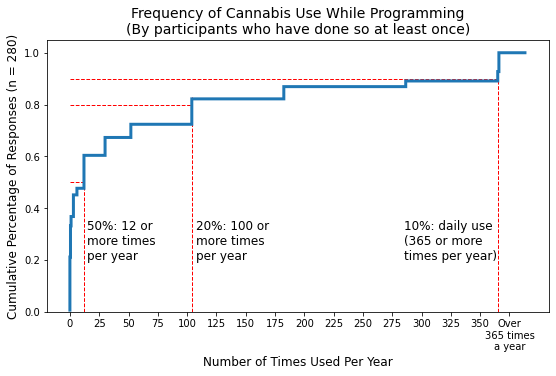

In [11]:
# And let's try and generate some sort of histogram here
y_axis_for_histogram, counts_for_histogram
# Now let's try and spread it out over the year
histogramer = []
for how_common, count in zip(y_axis_for_histogram, counts_for_histogram):
    histogramer += [how_common for x in range(0, count)]

plt.figure(figsize=(9,5)) #change your figure size as per your desire here
plt.ylabel('Cumulative Percentage of Responses (n = 280)', fontdict={'size': 12})
plt.xlabel('Number of Times Used Per Year', fontdict={'size': 12})
plt.title('Frequency of Cannabis Use While Programming\n(By participants who have done so at least once)', fontdict={'size': 14})

plt.hlines(0.9, 0, 365, colors='r', linestyles='dashed', linewidth=1)
plt.vlines(12, 0, 0.5, colors='r', linestyles='dashed', linewidth=1)
plt.text(15, 0.2, '50%: 12 or\nmore times\nper year', fontdict={'size': 12})


plt.hlines(0.8, 0, 103, colors='r', linestyles='dashed', linewidth=1)
plt.vlines(104.29, 0, 0.83, colors='r', linestyles='dashed', linewidth=1)
plt.text(107.7, 0.2, '20%: 100 or\nmore times\nper year', fontdict={'size': 12})

plt.hlines(0.5, 0, 12, colors='r', linestyles='dashed', linewidth=1)
plt.vlines(365, 0, 0.9, colors='r', linestyles='dashed', linewidth=1)
plt.text(285, 0.2, '10%: daily use\n(365 or more\ntimes per year)', fontdict={'size': 12})


plt.xticks(np.arange(0, 380, 25))
plt.xticks(np.arange(0, 380, 25), [str(x) for x in range(0, 355, 25)] + ['Over\n365 times\na year'])
#bins = sorted(X) + [np.inf]

plt.hist(histogramer, bins=[x/2 for x in range(0, 780)] + [np.inf], range = (0, 375), cumulative=True, density=True, histtype='step', linewidth=3)


plt.show()


Now let's look at percent usage of weed and percent usage of weed by age:
SpearmanrResult(correlation=0.20514053806703772, pvalue=0.0034850249845165284)


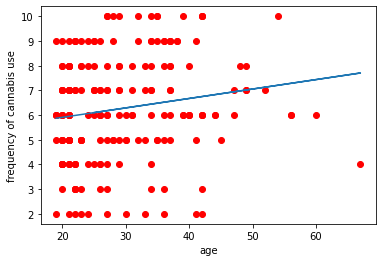

In [12]:
print("Now let's look at percent usage of weed and percent usage of weed by age:")

#Q5.1: Have you ever used cannabis
#Q5.3: Average frequency for using cannabis
#Q6.01: Have you ever used cannabis while programming
#Q6.03: Cannabis usage pattern by frequency

# Ok - first, let's correlate between age and frequency of use while programming
# Get those that answered that they have tried cannabis while programming
df_have_used_while_programming_and_age = num_data[(num_data['Q1.3'] > 0)&(num_data['Q6.02'] > 1)][['Q1.3', 'Q6.02']]
print(spearmanr(df_have_used_while_programming_and_age['Q1.3'], df_have_used_while_programming_and_age['Q6.02']))
x = df_have_used_while_programming_and_age['Q1.3']
plt.plot(x, df_have_used_while_programming_and_age['Q6.02'], 'ro')
plt.ylabel('frequency of cannabis use')
plt.xlabel('age')
m, b = np.polyfit(df_have_used_while_programming_and_age['Q1.3'], df_have_used_while_programming_and_age['Q6.02'], 1)
plt.plot(x, m*x + b)
plt.show()

# weak positive correlation: https://link.springer.com/article/10.1057/jt.2009.5

In [13]:
print("Now let's look at percent usage of weed and percent usage of weed by gender:")

women=1
men=2
transwomen=3
transmen=4
nonBinary=5
other=6

print_population_details('all participants', num_data)
print_population_details('men participants', num_data[(num_data['Q1.2'] == men)|(num_data['Q1.2'] == transmen)])
print_population_details('women participants', num_data[(num_data['Q1.2'] == women)|(num_data['Q1.2'] == transwomen)])
print_population_details('cisgender participants', num_data[(num_data['Q1.2'] == women)|(num_data['Q1.2'] == men)])
print_population_details('transgender participants', num_data[(num_data['Q1.2'] == transwomen)|(num_data['Q1.2'] == transmen)|(num_data['Q1.2'] == nonBinary)|(num_data['Q1.2'] == other)])


# Now let's run some proportion tests
print("First are men or women more likely to have tried cannabis?")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([463, 77]) # Number of users
n_obs = np.array([666, 112]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))

print("Now, are men or women more likely to have tried cannabis while programming?")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([241, 77]) # Number of users
n_obs = np.array([666, 112]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))

print("Finally, are trans or cis participants more likely to have tried cannabis?")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([533, 24]) # Number of users
n_obs = np.array([770, 28]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))

print("Finally, are trans or cis participants more likely to have tried cannabis while programming?")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([264, 16]) # Number of users
n_obs = np.array([770, 28]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))


Now let's look at percent usage of weed and percent usage of weed by gender:
Percent of all participants who have tried cannabis: 69.85% (542)
Percent of all participants who have tried cannabis while programming: 35.44% (275)
Average/Median use frequency of all participants who have tried cannabis: 5.73 6.0 (541)
Average/Median use frequency of all participants who have tried cannabis in last year: 7.46 8.0 (410)
Average/Median use frequency of all participants who have tried cannabis while programming: 4.65 5.0 (275)
Average/Median use frequency of all participants who have tried cannabis while programming in last year: 6.78 6.0 (184)

Percent of men participants who have tried cannabis: 70.12% (453)
Percent of men participants who have tried cannabis while programming: 36.84% (238)
Average/Median use frequency of men participants who have tried cannabis: 5.69 6.0 (452)
Average/Median use frequency of men participants who have tried cannabis in last year: 7.48 8.0 (339)
Average/Media

In [14]:
# Let's correct RQ1 for multpile comparisons - Benjamini–Hochberg (https://www.statisticshowto.com/benjamini-hochberg-procedure/)

print("Correcting for Multiple Comparisons for all statistical tests in RQ1. The True the farthest in this list means that all above it pass the threshold")

p_values = [8.813e-11, # men more likely to have tried cannabis while programming
            1.429e-03, # GitHub participants more likely to have tried cannabis while programming?
            0.0034, # Correlation between age and cannabis use
            1.279e-02, # Trans more likely than cis to have tried cannabis while programming
            6.187e-02, # Trans cs cis trying cannabis
            6.557e-02, # Github vs uni trying cannabis
            8.701e-01 # Women vs men trying cannabis
            ]
print(benjamini_hochberg(p_values, 0.05))

Correcting for Multiple Comparisons for all statistical tests in RQ1. The True the farthest in this list means that all above it pass the threshold
[(8.813e-11, 1, 0.007142857142857143, True), (0.001429, 2, 0.014285714285714285, True), (0.0034, 3, 0.02142857142857143, True), (0.01279, 4, 0.02857142857142857, True), (0.06187, 5, 0.03571428571428572, False), (0.06557, 6, 0.04285714285714286, False), (0.8701, 7, 0.05, False)]


# RQ2: Programming use context

This question investigates the context of when programmers use cannabis. Specifically, we investigate in terms of programming project context, software engineering task context, and remote work

In [15]:
print("Now let's look at when people use cannabis while programming")

def build_boolean_for_job_type(in_df):
    return ((in_df['Q6.08_1']==1)
        |(in_df['Q6.08_2']==1)
        |(in_df['Q6.08_3']==1)
        |(in_df['Q6.08_4']==1)
        |(in_df['Q6.08_5']==1)
        |(in_df['Q6.08_6']==1)
        |(in_df['Q6.08_0']==1))

# First get the columns relevant for this analysis:
needed_cols = [col for col in num_data if col.startswith('Q6.08')]
reasons_all = num_data[needed_cols]
reasons_cannabis = reasons_all[(reasons_all['Q6.08_1']==1)|(reasons_all['Q6.08_1']==-99.0)]
reasons_checked_at_least_one = reasons_all[build_boolean_for_job_type(reasons_all)]
reasons_checked_at_least_one_github = git_responses[needed_cols][build_boolean_for_job_type(git_responses)]
reasons_checked_at_least_one_umich = umich_responses[needed_cols][build_boolean_for_job_type(umich_responses)]


col_lab_map = {
                'Q6.08_1': [0,"school-related programming tasks"],
                'Q6.08_2': [0,"work-related programming tasks"],
                'Q6.08_3': [0,"personal programming projects"],
                'Q6.08_4': [0,"deadline-critical programming tasks"],
                'Q6.08_5': [0,"non-urgent programming tasks"],
                'Q6.08_6': [0,"I would use cannabis while programming, but my current workplace forbids it"],
                'Q6.08_0': [0,"I do not currently use cannabis while programming"]
            }
this_df = reasons_checked_at_least_one
results = [[this_df[col].value_counts()[1], len(this_df), col_lab_map[col]] for col in reasons_all]

# sort these from low to high
results.sort(reverse=True)

print("calculating for all responses:")
print("{0:60} {1:5} {2}".format("Label",  "Count", "Percent"))
for result in results:
    print("{0:60} {1:5} {2:>7.2f}".format(result[2][1], result[0], result[0]/result[1]*100))


Now let's look at when people use cannabis while programming
calculating for all responses:
Label                                                        Count Percent
personal programming projects                                  172   63.00
non-urgent programming tasks                                   131   47.99
work-related programming tasks                                  95   34.80
school-related programming tasks                                74   27.11
I do not currently use cannabis while programming               62   22.71
deadline-critical programming tasks                             25    9.16
I would use cannabis while programming, but my current workplace forbids it     5    1.83


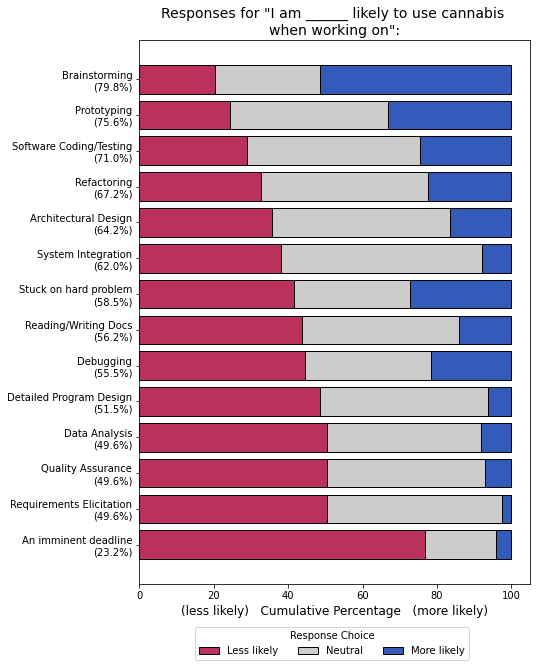

In [16]:
# Stacked box polt on what type of tasks do they use cannabis for
#Q6.10
col_lab_map = {
                'Q6.10_1': "An imminent deadline",
                'Q6.10_2': "Stuck on hard problem",
                'Q6.10_3': "Architectural Design",
                'Q6.10_4': "Brainstorming",
                'Q6.10_5': "Data Analysis",
                'Q6.10_6': "Detailed Program Design",
                'Q6.10_7': "Debugging",
                'Q6.10_8': "Prototyping",
                'Q6.10_9': "Quality Assurance",
                'Q6.10_10': "Reading/Writing Docs",
                'Q6.10_11': "Refactoring",
                'Q6.10_12': "Requirements Elicitation",
                'Q6.10_13': "Software Coding/Testing",
                'Q6.10_14': "System Integration"
}


needed_cols = [col for col in num_data if col.startswith('Q6.10')]
likert_results = []
for col in needed_cols:
    avg = num_data[num_data[col] > -99][col].mean()
    values = num_data[num_data[col] > -99][col].value_counts()
    likert_results.append([values[-1], values[-1]/sum(values)*100, values[0]/sum(values)*100, values[1]/sum(values)*100, col_lab_map[col] + '\n(' + str(round((values[0] + values[1])/sum(values)*100, 1)) + '%)'])

likert_results.sort(reverse=True)

less_likely = [x[1] for x in likert_results]
nuteral = [x[2] for x in likert_results]
more_likely = [x[3] for x in likert_results]
labels = [x[4] for x in likert_results]
Groups = np.array([less_likely, nuteral, more_likely])
Colors = ['#BA325B' , '0.8', '#325BBA']
plt.figure(figsize=(7,10))

Pos = range(14)
for i in range(len(Groups)):
    plt.barh(Pos, Groups[i], left = np.sum(Groups[:i], axis = 0), color = Colors[i], edgecolor = 'black')
    
plt.yticks(Pos, labels)

#plt.rcParams["figure.figsize"] = (4,15)
plt.xlabel("(less likely)   Cumulative Percentage   (more likely)", fontdict={'size': 12})
plt.title('Responses for "I am ______ likely to use cannabis \nwhen working on":', fontdict={'size': 14})
plt.legend(['Less likely', 'Neutral', 'More likely'], title = 'Response Choice', loc = 'best', bbox_to_anchor=(0.857, -0.07), ncol=3)
plt.show() 
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


In [17]:
print("Now let's look at percent usage of weed and percent usage of weed plus covid:")

#Q5.1: Have you ever used cannabis
#Q5.3: Average frequency for using cannabis
#Q6.01: Have you ever used cannabis while programming
#Q6.03: Cannabis usage pattern by frequency
# FIXME - add both requency of use ant form of cannabis to all of the above
print("More or less likely to use cannabis while programming post covid: - is less, + is more")
print(num_data['Q6.06'].value_counts())

print("Ok - let's do a statistical test for that last one (combind negative proportion vs combined positive proportion)")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([82, 27]) # Number of users
n_obs = np.array([280, 280]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))


print("More or less likely to use cannabis while working from home: - is less, + is more")
print(num_data['Q6.07'].value_counts())

print("Ok - let's do a statistical test for that last one (combind negative proportion vs combined positive proportion)")
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
count = np.array([145, 13]) # Number of users
n_obs = np.array([280, 280]) # total number asked
print_t_test_result(proportions_ztest(count, n_obs))


Now let's look at percent usage of weed and percent usage of weed plus covid:
More or less likely to use cannabis while programming post covid: - is less, + is more
 0.0     167
 1.0      64
 2.0      17
-2.0      13
-1.0      13
-99.0      2
Name: Q6.06, dtype: int64
Ok - let's do a statistical test for that last one (combind negative proportion vs combined positive proportion)
Test type: <class 'tuple'>, p = 4.352e-09, stat = 5.870

More or less likely to use cannabis while working from home: - is less, + is more
 0.0     118
 1.0      89
 2.0      55
-2.0       7
-1.0       5
-99.0      2
Name: Q6.07, dtype: int64
Ok - let's do a statistical test for that last one (combind negative proportion vs combined positive proportion)
Test type: <class 'tuple'>, p = 2.801e-35, stat = 12.394



In [18]:
# Let's correct RQ1 for multpile comparisons - Benjamini–Hochberg (https://www.statisticshowto.com/benjamini-hochberg-procedure/)

print("Correcting for Multiple Comparisons for all statistical tests in RQ2. The True the farthest in this list means that all above it pass the threshold")

p_values = [2.801e-35, # remote work
            4.352e-09 # covid
            ]
print(benjamini_hochberg(p_values, 0.05))

Correcting for Multiple Comparisons for all statistical tests in RQ2. The True the farthest in this list means that all above it pass the threshold
[(2.801e-35, 1, 0.025, True), (4.352e-09, 2, 0.05, True)]


# RQ3: Motivation for using cannabis while programming

Answers to question Q6.09: "Why do you use cannabis while programming, coding, or completing other software engineering-related tasks? [select all that apply]"

Possible Answers:

1) Wellbeing: To mitigate programming-related or programming-enhanced pain (e.g. back or wrist pain)
2) Wellbeing: To help with work-related or work-enhanced anxiety
3) Wellbeing: To help with work-related or work-enhanced social anxiety
4) Wellbeing: To help with work-related or work-enhanced migraines (e.g. screen fatigue)
5) Enjoyment: To make programming-related tasks more enjoyable
6) Help Programming: To think of more creative programming solutions
7) Help Programming: To gain insight or understanding
8) Help Programming: To enhance brainstorming
9) Help Programming: To focus on programming-related tasks
10) Help Programming: To get in a programming zone
11) Enjoyment: To make programming-related tasks less tedious
12) Enjoyment: To improve social interactions in the workplace
13) Enjoyment: To have fun in social programming settings
14) Wellbeing: I am unable to think as clearly without cannabis
15) Wellbeing: For non-programming related medical conditions
16) Other (please describe)


In [19]:

def build_boolean(in_df):
    return ((in_df['Q6.09_1']==1)
        |(in_df['Q6.09_2']==1)
        |(in_df['Q6.09_3']==1)
        |(in_df['Q6.09_4']==1)
        |(in_df['Q6.09_5']==1)
        |(in_df['Q6.09_6']==1)
        |(in_df['Q6.09_7']==1)
        |(in_df['Q6.09_8']==1)
        |(in_df['Q6.09_9']==1)
        |(in_df['Q6.09_10']==1)
        |(in_df['Q6.09_11']==1)
        |(in_df['Q6.09_12']==1)
        |(in_df['Q6.09_13']==1)
        |(in_df['Q6.09_14']==1)
        |(in_df['Q6.09_15']==1)
        |(in_df['Q6.09_16']==1))

# First get the columns relevant for this analysis:
needed_cols = [col for col in num_data if col.startswith('Q6.09')]
reasons_all = num_data[needed_cols]
reasons_cannabis = reasons_all[(reasons_all['Q6.09_1']==1)|(reasons_all['Q6.09_1']==-99.0)]
reasons_checked_at_least_one = reasons_all[build_boolean(reasons_all)]
reasons_checked_at_least_one_github = git_responses[needed_cols][build_boolean(git_responses)]
reasons_checked_at_least_one_umich = umich_responses[needed_cols][build_boolean(umich_responses)]


col_lab_map = {
                'Q6.09_1': [0,"To mitigate programming-related or programming-enhanced pain (e.g. back or wrist pain)"],
                'Q6.09_2': [0,"To help with work-related or work-enhanced anxiety"],
                'Q6.09_3': [0,"To help with work-related or work-enhanced social anxiety"],
                'Q6.09_4': [0,"To help with work-related or work-enhanced migraines (e.g. screen fatigue)"],
                'Q6.09_5': [1,"To make programming-related tasks more enjoyable"],
                'Q6.09_6': [2,"To think of more creative programming solutions"],
                'Q6.09_7': [2,"To gain insight or understanding"],
                'Q6.09_8': [2,"To enhance brainstorming"],
                'Q6.09_9': [2,"To focus on programming-related tasks"],
                'Q6.09_10': [2,"To get in a programming zone"],
                'Q6.09_11': [1,"To make programming-related tasks less tedious"],
                'Q6.09_12': [1,"To improve social interactions in the workplace"],
                'Q6.09_13': [1,"To have fun in social programming settings"],
                'Q6.09_14': [0,"I am unable to think as clearly without cannabis"],
                'Q6.09_15': [0,"For non-programming related medical conditions"],
                'Q6.09_16': [3,"Other (please describe)"]
            }

catategories = ["Wellness", "Enjoyment", "Programming", "Other"]


In [20]:
# Now, calculate the percentages of those who clicked it for each one for
this_df = reasons_checked_at_least_one
results = [[this_df[col].value_counts()[1], len(this_df), col_lab_map[col]] for col in reasons_all]

# sort these from low to high
results.sort(reverse=True)

print("calculating for all responses:")
print("{0:90} {1:15} {2:5} {3}".format("Label", "Category", "Count", "Percent"))
for result in results:
    print("{0:90} {1:<15} {2:5} {3:>7.2f}".format(result[2][1], catategories[result[2][0]], result[0], result[0]/result[1]*100))


this_df = reasons_checked_at_least_one_github
results = [[this_df[col].value_counts()[1], len(this_df), col_lab_map[col]] for col in reasons_all]

# sort these from low to high
results.sort(reverse=True)
print("\ncalculating for just open source responses:")
print("{0:90} {1:15} {2:5} {3}".format("Label", "Category", "Count", "Percent"))
for result in results:
    print("{0:90} {1:<15} {2:5} {3:>7.2f}".format(result[2][1], catategories[result[2][0]], result[0], result[0]/result[1]*100))

this_df = reasons_checked_at_least_one_umich
results = [[0 if len(this_df[col].value_counts()) == 1 else this_df[col].value_counts()[1], len(this_df), col_lab_map[col]] for col in reasons_all]

# sort these from low to high
results.sort(reverse=True)
print("\ncalculating for just umich responses:")
print("{0:90} {1:15} {2:5} {3}".format("Label", "Category", "Count", "Percent"))
for result in results:
    print("{0:90} {1:<15} {2:5} {3:>7.2f}".format(result[2][1], catategories[result[2][0]], result[0], result[0]/result[1]*100))

calculating for all responses:
Label                                                                                      Category        Count Percent
To make programming-related tasks more enjoyable                                           Enjoyment         144   60.50
To think of more creative programming solutions                                            Programming       125   52.52
To get in a programming zone                                                               Programming       115   48.32
To make programming-related tasks less tedious                                             Enjoyment         101   42.44
To enhance brainstorming                                                                   Programming        95   39.92
To focus on programming-related tasks                                                      Programming        79   33.19
To gain insight or understanding                                                           Programming        78   32.77
T

# RQ4: How about perceptions of cannabis use?

Answers to question Q6.09: "Why do you use cannabis while programming, coding, or completing other software engineering-related tasks? [select all that apply]"


In [21]:
# First, we'll get the subsets of data that are important between managers, employees, and students

# Current programming-related employees that are not managers
# And have a manager
df_non_manager_employees_with_manager = num_data[(num_data['Q2.18'] == -1)&(num_data['Q2.18b'] == 1)&(num_data['Q2.14'] == 1)] 

# Anyone who has ever had a programming-related job
df_all_who_have_worked = num_data[num_data['Q2.10'] == 1]

# Anyone who currently has a programming-related job
df_all_who_are_working_now = num_data[num_data['Q2.14'] == 1] 

all_who_are_students = num_data[num_data['Q1.5_3'] == 1]
all_who_are_full_time_employees = num_data[num_data['Q1.5_4'] == 1]
all_who_are_part_time_employees = num_data[num_data['Q1.5_5'] == 1]
all_who_are_self_employed = num_data[num_data['Q1.5_7'] == 1]


# Those who currently have a programming-related job: includes part-time, full-time, self-employed
df_current_workers = num_data[((num_data['Q1.5_4'] == 1)|(num_data['Q1.5_5'] == 1)|(num_data['Q1.5_7'] == 1))&(num_data['Q2.14'] == 1)]

#Those who are current programming managers:
df_managers = df_current_workers[(df_current_workers['Q2.18'] == 1)]

# Those who are programming employees but not currently managers
df_non_manager_employees = df_current_workers[(df_current_workers['Q2.18'] == -1)]

# Those who are programming workers and also not currently students
df_non_student_professionals = df_current_workers[(df_current_workers['Q1.5_3'] != 1)|((df_current_workers['Q1.5_3'] == 1)&(df_current_workers['Q2.8_7'] == 1))] # Where not a programming-related student

# Those who are current students in a programming-related field
df_current_programming_students = num_data[(num_data['Q2.8_1'] == 1)|(num_data['Q2.8_2'] == 1)|(num_data['Q2.8_3'] == 1)|(num_data['Q2.8_4'] == 1)|(num_data['Q2.8_5'] == 1)|(num_data['Q2.8_6'] == 1)]

print("All who currently have a programming-related job (full-time, part-time, self-employeed)", df_current_workers.shape) 
print("All those with a current programming job who are currently managers", df_managers.shape)
print("Current programming employees non-managers", df_non_manager_employees.shape)
print("Current programming professionals who are not students", df_non_student_professionals.shape) # Those who are programming-related employees who are not programming related students
print("Current programming students:", df_current_programming_students.shape)

print("\n\nAll who have had programming-related job:", df_all_who_have_worked.shape)
print("Currently students:", all_who_are_students.shape)
print("Currently full-time employees:", all_who_are_full_time_employees.shape)
print("Currently part-time employees:", all_who_are_part_time_employees.shape)
print("Currently self employees:", all_who_are_self_employed.shape)


All who currently have a programming-related job (full-time, part-time, self-employeed) (502, 376)
All those with a current programming job who are currently managers (186, 376)
Current programming employees non-managers (316, 376)
Current programming professionals who are not students (466, 376)
Current programming students: (220, 376)


All who have had programming-related job: (657, 376)
Currently students: (273, 376)
Currently full-time employees: (459, 376)
Currently part-time employees: (74, 376)
Currently self employees: (43, 376)


In [22]:
# Now, let's look at the perception differences between the groups - let's start with managers and employees

print("Now on to different attitudes about weed and programming in particular")

# Q4.5 is disaprove of a collegue or teammate - not asked to managers
# Q4.6 is what do you think your manager would think? Only to employees - not asked to managers
# Q4.7 As a manager, would you disaprove if your employee....
 
df_4p5 = df_non_manager_employees[(df_non_manager_employees['Q4.5_1']!=-99)&(df_non_manager_employees['Q4.5_2']!=-99)&(df_non_manager_employees['Q4.5_3']!=-99)&(df_non_manager_employees['Q4.5_4']!=-99)]
score_4p5 = df_4p5[['Q4.5_1', 'Q4.5_2', 'Q4.5_3', 'Q4.5_4']].mean(axis=1)

df_4p6 = df_non_manager_employees[(df_non_manager_employees['Q4.6_1']!=-99)&(df_non_manager_employees['Q4.6_2']!=-99)&(df_non_manager_employees['Q4.6_3']!=-99)&(df_non_manager_employees['Q4.6_4']!=-99)]
score_4p6 = df_4p6[['Q4.6_1', 'Q4.6_2', 'Q4.6_3', 'Q4.6_4']].mean(axis=1)

df_4p7 = df_managers[(df_managers['Q4.7_1']!=-99)&(df_managers['Q4.7_2']!=-99)&(df_managers['Q4.7_3']!=-99)&(df_managers['Q4.7_4']!=-99)]
score_4p7 = df_4p7[['Q4.7_1', 'Q4.7_2', 'Q4.7_3', 'Q4.7_4']].mean(axis=1)


print("Are managers more positive on weed than employees think they would be? Answer - yes\n")
summary_statistics(("Managers thoughts on employees", score_4p7), ("What employees think managers think", score_4p6))
print_t_test_result(ttest_ind(score_4p7, score_4p6, equal_var=False, alternative='two-sided', nan_policy='omit'))

print("Do managers disaprove more about weed use by their employess than employees do of their collegues?\n")
summary_statistics(("Managers thoughts on employees", score_4p7), ("Employees on collegues", score_4p5))
print_t_test_result(ttest_ind(score_4p7, score_4p5, equal_var=False, alternative='two-sided', nan_policy='omit'))

print("For a final difference between manager and employee perceptions - how likely are you to know someone at your workplace that uses weed?")

#Q4.10: Do you know a collegue at your current workplace who uses it on the job?
#Q4.11: Do you know a manager at your current workplace who uses it on the job?

know_coll = df_current_workers[df_current_workers['Q4.10']!=-99]['Q4.10']
know_manager = df_current_workers[df_current_workers['Q4.11']!=-99]['Q4.11']
print(know_coll.value_counts())
print(know_manager.value_counts())
summary_statistics(("Do you know a collegue who uses", know_coll), ("Do you know a manager who uses", know_manager))
print_t_test_result(ttest_ind(know_coll, know_manager, equal_var=False, alternative='two-sided'))



Now on to different attitudes about weed and programming in particular
Are managers more positive on weed than employees think they would be? Answer - yes

Number of Managers thoughts on employees: 185, Number of What employees think managers think: 297
Mean of Managers thoughts on employees: -0.508, Mean of What employees think managers think: -1.023
Median of Managers thoughts on employees: -0.250, Median of What employees think managers think: -1.000
Stdev of Managers thoughts on employees: 0.987, Stdev of What employees think managers think: 0.835
Test type: <class 'scipy.stats.mstats_basic.Ttest_indResult'>, p = 8.935e-09, stat = 5.896

Do managers disaprove more about weed use by their employess than employees do of their collegues?

Number of Managers thoughts on employees: 185, Number of Employees on collegues: 315
Mean of Managers thoughts on employees: -0.508, Mean of Employees on collegues: -0.359
Median of Managers thoughts on employees: -0.250, Median of Employees on colle

In [23]:
# So we found that employees think managers will think less of them than they 
# disapprove of their colleges, but no signifciant difference of effect on what managers think
# Is there any difference in usage between the two groups?

print("Now for usage differences between managers and employees\n")

#Q5.1: Have you ever used cannabis
#Q5.3: Average frequency for using cannabis
#Q6.01: Have you ever used cannabis while programming
#Q6.03: Cannabis usage pattern by frequency

print("First, are managers more likely to have tried weed in general - answer no?")
non_manager_has_used = df_non_manager_employees[df_non_manager_employees['Q5.1']!=-99]['Q5.1']
manager_has_used = df_managers[df_managers['Q5.1']!=-99]['Q5.1']
summary_statistics(("Managers", manager_has_used), ("Non managers", non_manager_has_used))
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
m_values = manager_has_used.value_counts()
nm_values = non_manager_has_used.value_counts()
count = np.array([m_values[1.0], nm_values[1.0]]) # Number of users
nobs = np.array([sum(m_values), sum(nm_values)]) # total number asked
print_t_test_result(proportions_ztest(count, nobs))

print("Now, are managers who have tried or less likely to have tried weed while programming than employees? - answer = no")
non_manager_has_used = df_non_manager_employees[df_non_manager_employees['Q6.01']!=-99]['Q6.01']
manager_has_used = df_managers[df_managers['Q6.01']!=-99]['Q6.01']
summary_statistics(("Managers who have used weed", manager_has_used), ("Non managers who have used weed", non_manager_has_used))
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
m_values = manager_has_used.value_counts()
nm_values = non_manager_has_used.value_counts()
count = np.array([m_values[1.0], nm_values[1.0]]) # Number of users
nobs = np.array([len(manager_has_used), len(non_manager_has_used)]) # total number asked
print_t_test_result(proportions_ztest(count, nobs))

#FIXME: Control for age?
print("Finally, are managers who have used weed while programming more or less likely to use it while programming in the last year? - answer = no")
managers_frequency = df_managers[df_managers['Q6.03']!=-99]['Q6.03']
employees_frequency = df_non_manager_employees[df_non_manager_employees['Q6.03']!=-99]['Q6.03']
summary_statistics(("Managers", managers_frequency), ("Employees", employees_frequency))
print_t_test_result(ttest_ind(managers_frequency, employees_frequency, equal_var=True, alternative='two-sided', nan_policy='omit'))

Now for usage differences between managers and employees

First, are managers more likely to have tried weed in general - answer no?
Number of Managers: 186, Number of Non managers: 316
Mean of Managers: 0.505, Mean of Non managers: 0.411
Median of Managers: 1.000, Median of Non managers: 1.000
Stdev of Managers: 0.865, Stdev of Non managers: 0.913
Test type: <class 'tuple'>, p = 2.558e-01, stat = 1.136

Now, are managers who have tried or less likely to have tried weed while programming than employees? - answer = no
Number of Managers who have used weed: 140, Number of Non managers who have used weed: 222
Mean of Managers who have used weed: 0.043, Mean of Non managers who have used weed: 0.081
Median of Managers who have used weed: 1.000, Median of Non managers who have used weed: 1.000
Stdev of Managers who have used weed: 1.003, Stdev of Non managers who have used weed: 0.999
Test type: <class 'tuple'>, p = 7.979e-01, stat = 0.256

Finally, are managers who have used weed while pro

In [24]:
# Now, let's look at perception differences between programming students (both employees and not) 
# and non-student programming employees

print("Now on to different perceptions about weed and programming between current programming students and current non-student programming workers")

# Q4.4 student disaprove of abother student
# Q4.5 is disaprove of a collegue or teammate - not asked to managers
 
df_4p5 = df_non_student_professionals[(df_non_student_professionals['Q4.5_1']!=-99)&(df_non_student_professionals['Q4.5_2']!=-99)&(df_non_student_professionals['Q4.5_3']!=-99)&(df_non_student_professionals['Q4.5_4']!=-99)]
score_4p5 = df_4p5[['Q4.5_1', 'Q4.5_2', 'Q4.5_3', 'Q4.5_4']].mean(axis=1)

df_4p4 = df_current_programming_students[(df_current_programming_students['Q4.4_1']!=-99)&(df_current_programming_students['Q4.4_2']!=-99)&(df_current_programming_students['Q4.4_3']!=-99)&(df_current_programming_students['Q4.4_4']!=-99)]
score_4p4 = df_4p4[['Q4.4_1', 'Q4.4_2', 'Q4.4_3', 'Q4.4_4']].mean(axis=1)

print("Are students more positive on other students using weed than employees are on other employees? - answer no\n")
summary_statistics(("Students thoughts on students", score_4p4), ("Employees on collegues", score_4p5))
print_t_test_result(ttest_ind(score_4p4, score_4p5, equal_var=True, alternative='two-sided', nan_policy='omit'))

know_coll = df_non_student_professionals[df_non_student_professionals['Q4.10']!=-99]['Q4.10']
know_student = df_current_programming_students[df_current_programming_students['Q4.12']!=-99]['Q4.12']
summary_statistics(("Do you know a collegue who uses", know_coll), ("Do you know a student who uses", know_student))
print(know_coll.value_counts())
print(know_student.value_counts())
print_t_test_result(ttest_ind(know_coll, know_student, equal_var=True, alternative='two-sided'))

Now on to different perceptions about weed and programming between current programming students and current non-student programming workers
Are students more positive on other students using weed than employees are on other employees? - answer no

Number of Students thoughts on students: 220, Number of Employees on collegues: 288
Mean of Students thoughts on students: -0.252, Mean of Employees on collegues: -0.335
Median of Students thoughts on students: -0.250, Median of Employees on collegues: -0.250
Stdev of Students thoughts on students: 1.017, Stdev of Employees on collegues: 1.029
Test type: <class 'scipy.stats.mstats_basic.Ttest_indResult'>, p = 3.668e-01, stat = 0.903

Number of Do you know a collegue who uses: 465, Number of Do you know a student who uses: 219
Mean of Do you know a collegue who uses: -0.237, Mean of Do you know a student who uses: 0.379
Median of Do you know a collegue who uses: 0.000, Median of Do you know a student who uses: 0.000
Stdev of Do you know a coll

In [25]:
# Finally, let's look at usage differences between students and workers
print("Now for usage differences between current non-student workers and programming students\n")

#Q5.1: Have you ever used cannabis
#Q5.3: Average frequency for using cannabis
#Q6.01: Have you ever used cannabis while programming
#Q6.03: Cannabis usage pattern by frequency

print("First, are students more likely to have tried weed in general - no - trend towards less likely?")
workers = df_non_student_professionals[df_non_student_professionals['Q5.1']!=-99]['Q5.1']
students = df_current_programming_students[df_current_programming_students['Q5.1']!=-99]['Q5.1']
summary_statistics(("All programming students", students), ("All non-student workers", workers))
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
m_values = students.value_counts()
nm_values = workers.value_counts()
count = np.array([m_values[1.0], nm_values[1.0]]) # Number of users
nobs = np.array([sum(m_values), sum(nm_values)]) # total number asked
print_t_test_result(proportions_ztest(count, nobs))

print("Now, are students who have tried weed more or less likely to have tried weed while programming? - answer = they are less likely")
workers_have_used_weed = df_non_student_professionals[df_non_student_professionals['Q6.01']!=-99]['Q6.01']
student_has_used = df_current_programming_students[df_current_programming_students['Q6.01']!=-99]['Q6.01']
summary_statistics(("Students who have used weed", student_has_used), ("Workers who have used weed", workers_have_used_weed))
# Using n-1 chi squared test which is equivelent to a z-proportions test for a 2x2: https://pubmed.ncbi.nlm.nih.gov/17315184/
m_values = student_has_used.value_counts()
nm_values = workers_have_used_weed.value_counts()
count = np.array([m_values[1.0], nm_values[1.0]]) # Number of users
nobs = np.array([len(student_has_used), len(workers_have_used_weed)]) # total number asked
print_t_test_result(proportions_ztest(count, nobs))

#FIXME: Control for age?
print("Finally, are students who use weed while programming more or less likely to use it while programming in the last year? - no difference")
student_frequency = df_current_programming_students[df_current_programming_students['Q6.03']!=-99]['Q6.03']
workers_frequency = df_non_student_professionals[df_non_student_professionals['Q6.03']!=-99]['Q6.03']
summary_statistics(("Students", student_frequency), ("Workers", workers_frequency))
print_t_test_result(ttest_ind(student_frequency, workers_frequency, equal_var=False, alternative='two-sided', nan_policy='omit'))

Now for usage differences between current non-student workers and programming students

First, are students more likely to have tried weed in general - no - trend towards less likely?
Number of All programming students: 220, Number of All non-student workers: 466
Mean of All programming students: 0.345, Mean of All non-student workers: 0.442
Median of All programming students: 1.000, Median of All non-student workers: 1.000
Stdev of All programming students: 0.941, Stdev of All non-student workers: 0.898
Test type: <class 'tuple'>, p = 1.951e-01, stat = -1.296

Now, are students who have tried weed more or less likely to have tried weed while programming? - answer = they are less likely
Number of Students who have used weed: 148, Number of Workers who have used weed: 335
Mean of Students who have used weed: -0.041, Mean of Workers who have used weed: 0.087
Median of Students who have used weed: -1.000, Median of Workers who have used weed: 1.000
Stdev of Students who have used weed: 1.

In [26]:
# DRUG TEST STUFF
print("Number of responders who have had to take a drug test for a programming-related job:")
print(cat_data['Q4.13'].value_counts())

print("Number of responders to the question asking if their work place has drug policy: 1 means yes, 0 is unsure, 2 is no:")
print(df_all_who_are_working_now['Q4.15'].value_counts())


Number of responders who have had to take a drug test for a programming-related job:
No     544
Yes    223
-99      2
Name: Q4.13, dtype: int64
Number of responders to the question asking if their work place has drug policy: 1 means yes, 0 is unsure, 2 is no:
 0.0     214
-1.0     214
 1.0     124
-99.0      1
Name: Q4.15, dtype: int64


In [27]:
# General Cannabis Use Thoughts

print("First, let's see legalization views in general \n")
weed_legalization = num_data[num_data['Q4.1']!=-99]['Q4.1']
print(weed_legalization.value_counts())

print("Next, let's check if they have different views on the risk of using weed - answer, no - managers do not more risk\n")
weed_risk = num_data[num_data['Q4.2']!=-99]['Q4.2']
print(weed_risk.value_counts())


First, let's see legalization views in general 

2.0    704
1.0     54
0.0     17
Name: Q4.1, dtype: int64
Next, let's check if they have different views on the risk of using weed - answer, no - managers do not more risk

1.0    380
0.0    254
2.0    105
3.0     37
Name: Q4.2, dtype: int64


In [28]:
print("And, let's see if managers ever report reprimanding cannabis use:")

print("First - let's see if managers suspect supervisee cannabis use\n")
weed_reprimand = df_managers[df_managers['Q4.18_1']!=-99]['Q4.18_1']
print(weed_reprimand.value_counts())

print("First - let's see if managers think cannabis-using programmers are less productive\n")
weed_reprimand = df_managers[df_managers['Q4.18_6']!=-99]['Q4.18_6']
print(weed_reprimand.value_counts())

print("First - let's see if managers think cannabis-using programmers are less productive\n")
weed_reprimand = df_managers[df_managers['Q4.18_7']!=-99]['Q4.18_7']
print(weed_reprimand.value_counts())

And, let's see if managers ever report reprimanding cannabis use:
First - let's see if managers suspect supervisee cannabis use

 0.0    75
-1.0    59
 1.0    50
Name: Q4.18_1, dtype: int64
First - let's see if managers think cannabis-using programmers are less productive

 0.0    129
-1.0     48
 1.0      5
Name: Q4.18_6, dtype: int64
First - let's see if managers think cannabis-using programmers are less productive

-1.0    166
 0.0     17
 1.0      1
Name: Q4.18_7, dtype: int64


In [29]:
# Let's correct RQ4 for multpile comparisons - Benjamini–Hochberg (https://www.statisticshowto.com/benjamini-hochberg-procedure/)

print("Correcting for Multiple Comparisons for all statistical tests in RQ4. The True the farthest in this list means that all above it pass the threshold")

p_values = [1.889e-09, # What do employees think their managers will think?
            1.524e-01, # What's the ground truth of the above?
            3.729e-12, # Visibility between managers and collegues
            1.747e-01, # Are managers or employees more or less likley to have tried weed?
            8.147e-01, # Managers vs employees - tried weed while programming
            3.310e-01, # Managers vs employees - use in the last year
            2.569e-01, # Student on student vs employee on employee
            1.239e-09, # Student visibility vs employee visibility
            1.240e-01, # General cannabis usage difference between employees and students
            9.138e-02, # Cannabis usage while programming differences employees vs students
            5.250e-01 # Cannabis frequency of use employees vs students
]
            
print(benjamini_hochberg(p_values, 0.05))

Correcting for Multiple Comparisons for all statistical tests in RQ4. The True the farthest in this list means that all above it pass the threshold
[(3.729e-12, 1, 0.004545454545454546, True), (1.239e-09, 2, 0.009090909090909092, True), (1.889e-09, 3, 0.013636363636363636, True), (0.09138, 4, 0.018181818181818184, False), (0.124, 5, 0.022727272727272728, False), (0.1524, 6, 0.02727272727272727, False), (0.1747, 7, 0.03181818181818182, False), (0.2569, 8, 0.03636363636363637, False), (0.331, 9, 0.040909090909090916, False), (0.525, 10, 0.045454545454545456, False), (0.8147, 11, 0.05, False)]
